Sample data:
   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  

Missing values:
customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outs

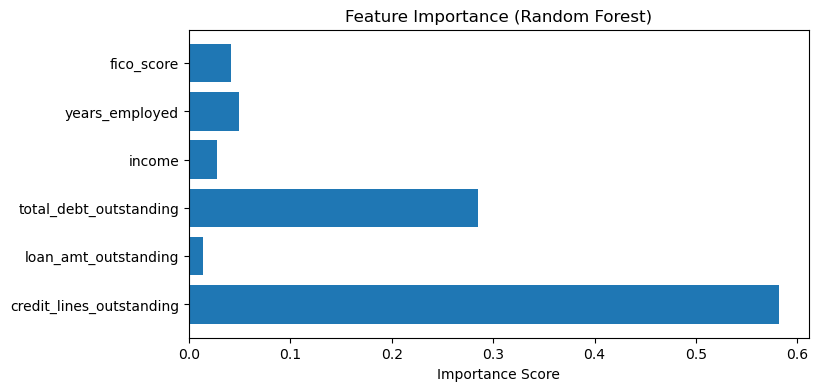


Prediction for Example Borrower:
{'PD': 0.04, 'Expected Loss': 180.0}


In [2]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Step 2: Load the data
# Replace the path below with your file path
df = pd.read_csv(r"C:\Users\ragha\Desktop\Quantitaive research\task 3 credir risk pd model\Task 3 and 4_Loan_Data.csv")
print("Sample data:")
print(df.head())

# Step 3: Quick data check
print("\nMissing values:")
print(df.isnull().sum())

print("\nData summary:")
print(df.describe())

print("\nClass distribution:")
print(df['default'].value_counts(normalize=True))

# Step 4: Feature selection and preprocessing
features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding',
            'income', 'years_employed', 'fico_score']
X = df[features]
y = df['default']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model training

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict_proba(X_test_scaled)[:, 1]
lr_auc = roc_auc_score(y_test, lr_preds)
print(f"\nLogistic Regression AUC: {lr_auc:.4f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"Random Forest AUC: {rf_auc:.4f}")

# Step 6: Feature importance (for Random Forest)
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8, 4))
plt.barh(feat_names, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

# Step 7: Expected Loss Function
def calculate_expected_loss(borrower_data, model=rf, scaler=scaler):
    """
    borrower_data: dict of input features
    model: trained classification model
    scaler: StandardScaler (optional, for logistic regression)
    Returns PD and Expected Loss
    """
    # Extract EAD
    ead = borrower_data['loan_amt_outstanding']
    lgd = 0.9  # 90% loss given default

    # Create DataFrame for model input
    X_input = pd.DataFrame([borrower_data])[features]

    # Scaling if logistic regression
    # X_input_scaled = scaler.transform(X_input)  # Uncomment if using LR
    # pd_estimate = model.predict_proba(X_input_scaled)[:, 1][0]  # For LR

    pd_estimate = model.predict_proba(X_input)[:, 1][0]  # For RF

    expected_loss = pd_estimate * ead * lgd

    return {
        'PD': round(pd_estimate, 4),
        'Expected Loss': round(expected_loss, 2)
    }

# Step 8: Test the function
example_borrower = {
    'credit_lines_outstanding': 2,
    'loan_amt_outstanding': 5000,
    'total_debt_outstanding': 7000,
    'income': 45000,
    'years_employed': 3,
    'fico_score': 600
}

result = calculate_expected_loss(example_borrower)
print("\nPrediction for Example Borrower:")
print(result)
